In [83]:
#*****************************************
# Name: Jonah Zembower
# Date: January 22, 2025
# Project: EY Data Science 2025 Challenge
#*****************************************

# Importing Data

Import necessary python packages for loading and manipulating the data.

In [84]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import jet,RdYlGn

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

Begin to load the datasets.

In [85]:
# Import the training data
training_data = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Training_data_uhi_index.csv")
training_data

Longitude   Latitude          datetime  UHI Index
0     -73.909167  40.813107  24-07-2021 15:53   1.030289
1     -73.909187  40.813045  24-07-2021 15:53   1.030289
2     -73.909215  40.812978  24-07-2021 15:53   1.023798
3     -73.909242  40.812908  24-07-2021 15:53   1.023798
4     -73.909257  40.812845  24-07-2021 15:53   1.021634
...          ...        ...               ...        ...
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408

[11229 rows x 4 columns]

# Landsat:

Obtaining the band values for the dataset.

In [86]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [87]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [88]:
# Define the time window
# We will use the training data day to search for data
time_window = "2021-05-01/2021-08-31"

In [89]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 50},"platform": {"in": ["landsat-8"]}},
)

In [90]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 11


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, Surface Temperature). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 30-meters. 

In [91]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [92]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

### Landsat Band Summary 
The following list of bands will be loaded by the Open Data Cube (ODC) stac command:<br>
We will use two load commands to separate the RGB data from the Surface Temperature data.<br><br>
Band 2 = blue = 30m<br>
Band 3 = green = 30m<br>
Band 4 = red = 30m<br>
Band 5 = nir08 (near infrared) = 30m<br>
Band 11 = Surface Temperature = lwir11 = 100m

In [93]:
data1 = stac_load(
    items,
    bands=["red", "green", "blue", "nir08"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [94]:
data2 = stac_load(
    items,
    bands=["lwir11"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [95]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data1)
display(data2)

<xarray.Dataset> Size: 213MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 11)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 88B 2021-05-06T15:38:57.276261 ... 202...
Data variables:
    red          (time, latitude, longitude) uint16 53MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 53MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 53MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    nir08        (time, latitude, longitude) uint16 53MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

<xarray.Dataset> Size: 53MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 11)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 88B 2021-05-06T15:38:57.276261 ... 202...
Data variables:
    lwir11       (time, latitude, longitude) uint16 53MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

In [96]:
# Persist the data in memory for faster operations
data1 = data1.persist()
data2 = data2.persist()

In [97]:
# Scale Factors for the RGB and NIR bands 
scale1 = 0.0000275 
offset1 = -0.2 
data1 = data1.astype(float) * scale1 + offset1

In [98]:
# Scale Factors for the Surface Temperature band
scale2 = 0.00341802 
offset2 = 149.0 
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
data2 = data2.astype(float) * scale2 + offset2 - kelvin_celsius

### View RGB (real color) images from the time series
You will notice that some of the scenes have clouds and some of the scenes have missing data due to scene boundary issues. Since Landsat is a descending orbit path across the equator, the time of acquisition for the scenes below is about 11:30am local time (note the time on the image is UTC time). Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. 

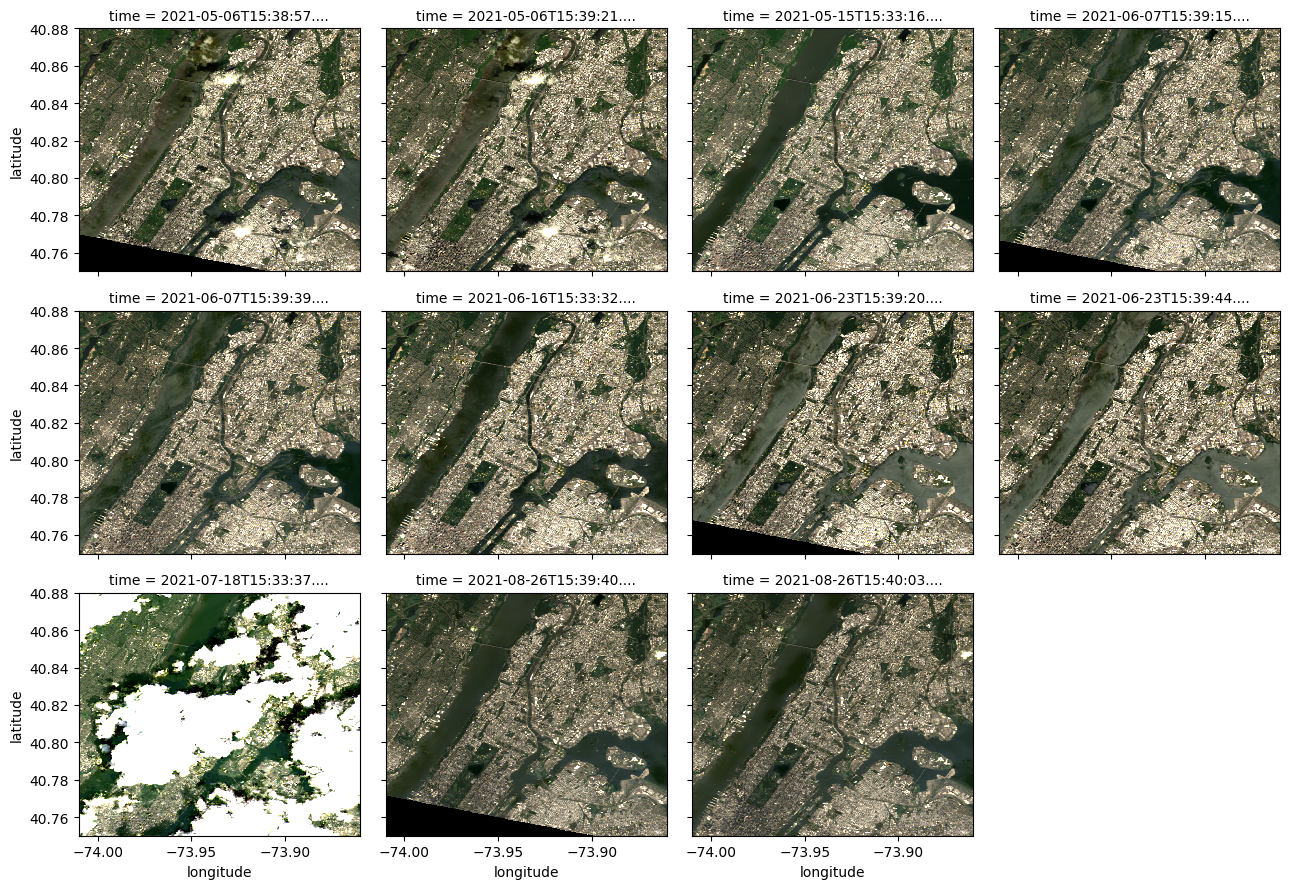

In [99]:
plot_data = data1[["red","green","blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

We chose May 15, 2021 because the weather data was similar to what was experienced on July 24, 2021 from the training data. It was also a clear image for us to use. 

In [100]:
# Pick one of the scenes above (numbering starts with 0)
scene = 2

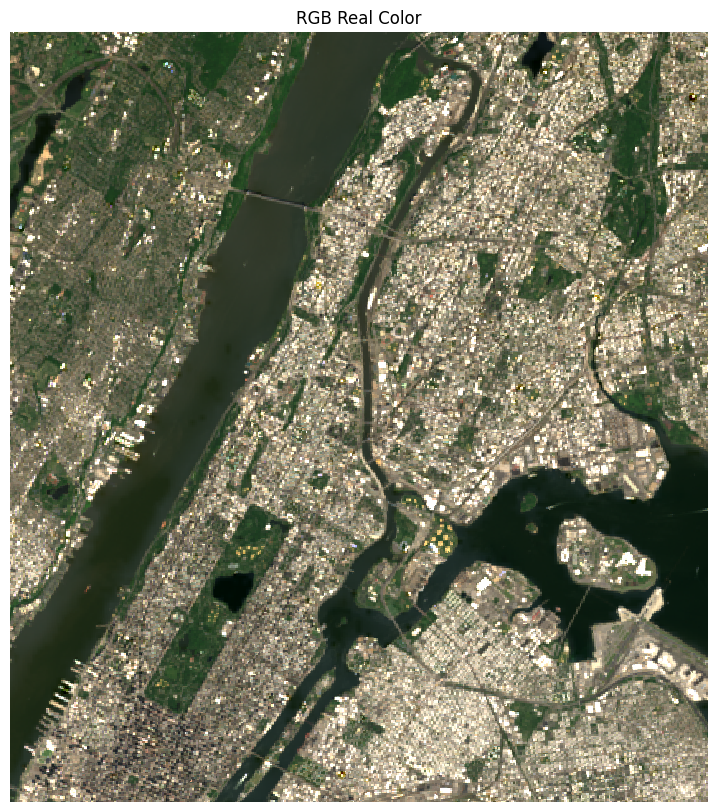

In [101]:
# Plot an RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(9,10))
data1.isel(time=scene)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0.0, vmax=0.25)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. Such information can be relevant to modeling urban heating as the proximity to vegetation or "green space" can mitigate urban heating. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [102]:
# Calculate NDVI for the median mosaic
ndvi_data = (data1.isel(time=scene).nir08-data1.isel(time=scene).red)/(data1.isel(time=scene).nir08+data1.isel(time=scene).red)

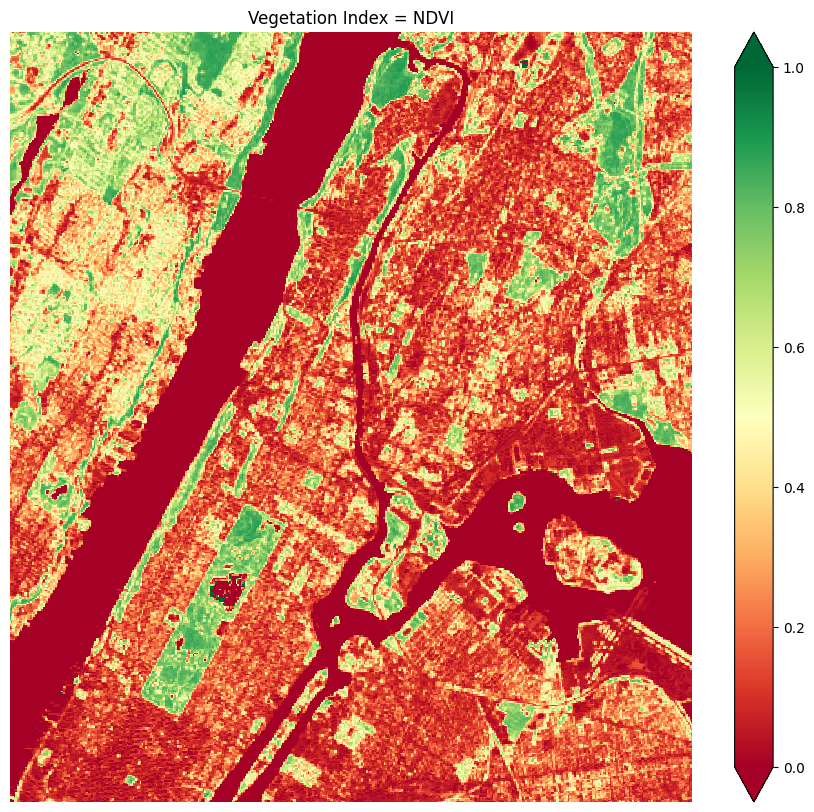

In [103]:
fig, ax = plt.subplots(figsize=(11,10))
ndvi_data.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Vegetation Index = NDVI")
plt.axis('off')
plt.show()

### Land Surface Temperature:

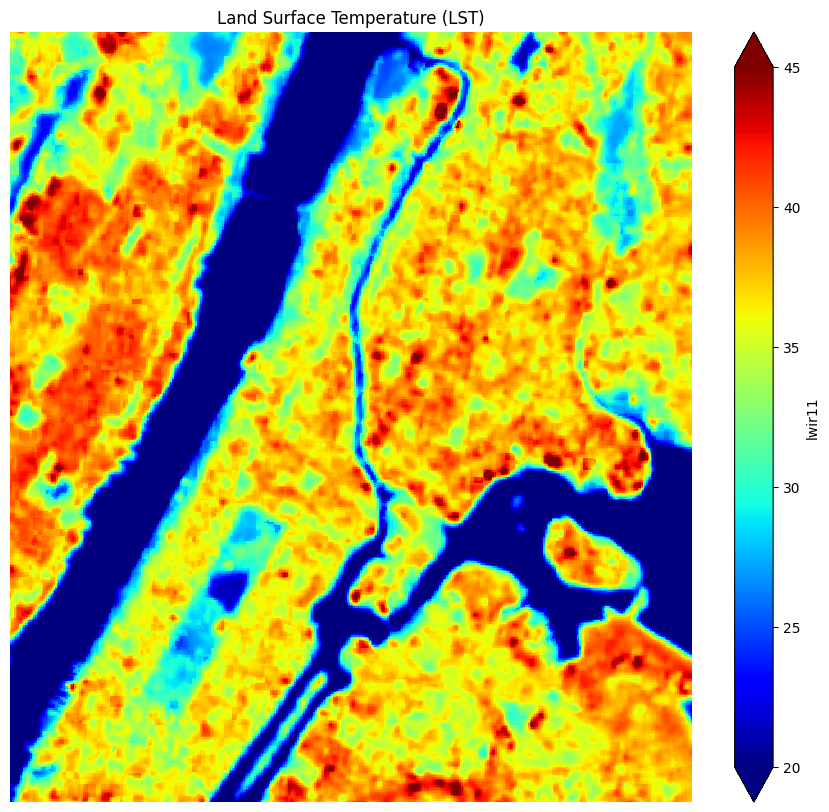

In [104]:
fig, ax = plt.subplots(figsize=(11,10))
data2.isel(time=scene).lwir11.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('off')
plt.show()

### Save the output data in a GeoTIFF file

In [105]:
# Only select one of the time slices to output
data3 = data2.isel(time=scene)

In [106]:
filename = "Landsat_LST_May_15_2021.tiff"

In [107]:
# Calculate the dimensions of the file
height = data3.dims["latitude"]
width = data3.dims["longitude"]

In [108]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data3.rio.write_crs("epsg:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True)

<xarray.Dataset> Size: 19MB
Dimensions:      (latitude: 1448, longitude: 1671)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    time         datetime64[ns] 8B 2021-05-15T15:33:16.857996
    spatial_ref  int64 8B 0
Data variables:
    lwir11       (latitude, longitude) float64 19MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>

In [109]:
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=1,compress='lzw',dtype='float64') as dst:
    dst.write(data3.lwir11,1)
    dst.close()

Grab the other landsat bands:

In [110]:
# Only select one of the time slices to output
data4 = data1.isel(time=scene)

In [111]:
filename = "Landsat_LST_bands_May_15_2021.tiff"

In [112]:
# Calculate the dimensions of the file
height = data4.dims["latitude"]
width = data4.dims["longitude"]

In [113]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data4.rio.write_crs("epsg:4326", inplace=True)
data4.rio.write_transform(transform=gt, inplace=True)

<xarray.Dataset> Size: 77MB
Dimensions:      (latitude: 1448, longitude: 1671)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    time         datetime64[ns] 8B 2021-05-15T15:33:16.857996
    spatial_ref  int64 8B 0
Data variables:
    red          (latitude, longitude) float64 19MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    green        (latitude, longitude) float64 19MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    blue         (latitude, longitude) float64 19MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    nir08        (latitude, longitude) float64 19MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>

In [114]:
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=4,compress='lzw',dtype='float64') as dst:
    dst.write(data4.red, 1)
    dst.write(data4.green, 2)
    dst.write(data4.blue, 3)
    dst.write(data4.nir08, 4)
    dst.close()

### Showcase the Data for the Landsat Image:

In [115]:
# Open the GeoTIFF file
with rasterio.open('Landsat_LST_May_15_2021.tiff') as src:
    # Read the data
    lst_data = src.read(1)
    # Get the affine transformation of the GeoTIFF
    transform = src.transform

# Function to get the LST value for a given longitude and latitude
def get_lst_value(lon, lat):
    row, col = ~transform * (lon, lat)
    row, col = int(row), int(col)
    # Ensure the indices are within bounds
    if 0 <= row < lst_data.shape[0] and 0 <= col < lst_data.shape[1]:
        return lst_data[row, col]
    else:
        return None

# Add the LST values to the training data
training_data['Thermal'] = training_data.apply(lambda row: get_lst_value(row['Longitude'], row['Latitude']), axis=1)


In [116]:
# Open the GeoTIFF file
with rasterio.open('Landsat_LST_bands_May_15_2021.tiff') as src:
    # Read the data
    lst_data = src.read(1)
    # Get the affine transformation of the GeoTIFF
    transform = src.transform

# Function to get the LST value for a given longitude and latitude
def get_lst_value(lon, lat):
    row, col = ~transform * (lon, lat)
    row, col = int(row), int(col)
    # Ensure the indices are within bounds
    if 0 <= row < lst_data.shape[0] and 0 <= col < lst_data.shape[1]:
        return lst_data[row, col]
    else:
        return None

# Add the LST values to the training data
training_data['Red'] = training_data.apply(lambda row: get_lst_value(row['Longitude'], row['Latitude']), axis=1)

In [117]:
# Open the GeoTIFF file
with rasterio.open('Landsat_LST_bands_May_15_2021.tiff') as src:
    # Read the data
    lst_data = src.read(2)
    # Get the affine transformation of the GeoTIFF
    transform = src.transform

# Function to get the LST value for a given longitude and latitude
def get_lst_value(lon, lat):
    row, col = ~transform * (lon, lat)
    row, col = int(row), int(col)
    # Ensure the indices are within bounds
    if 0 <= row < lst_data.shape[0] and 0 <= col < lst_data.shape[1]:
        return lst_data[row, col]
    else:
        return None

# Add the LST values to the training data
training_data['Green'] = training_data.apply(lambda row: get_lst_value(row['Longitude'], row['Latitude']), axis=1)

In [118]:
# Open the GeoTIFF file
with rasterio.open('Landsat_LST_bands_May_15_2021.tiff') as src:
    # Read the data
    lst_data = src.read(3)
    # Get the affine transformation of the GeoTIFF
    transform = src.transform

# Function to get the LST value for a given longitude and latitude
def get_lst_value(lon, lat):
    row, col = ~transform * (lon, lat)
    row, col = int(row), int(col)
    # Ensure the indices are within bounds
    if 0 <= row < lst_data.shape[0] and 0 <= col < lst_data.shape[1]:
        return lst_data[row, col]
    else:
        return None

# Add the LST values to the training data
training_data['Blue'] = training_data.apply(lambda row: get_lst_value(row['Longitude'], row['Latitude']), axis=1)

In [119]:
# Open the GeoTIFF file
with rasterio.open('Landsat_LST_bands_May_15_2021.tiff') as src:
    # Read the data
    lst_data = src.read(4)
    # Get the affine transformation of the GeoTIFF
    transform = src.transform

# Function to get the LST value for a given longitude and latitude
def get_lst_value(lon, lat):
    row, col = ~transform * (lon, lat)
    row, col = int(row), int(col)
    # Ensure the indices are within bounds
    if 0 <= row < lst_data.shape[0] and 0 <= col < lst_data.shape[1]:
        return lst_data[row, col]
    else:
        return None

# Add the LST values to the training data
training_data['Near Infared'] = training_data.apply(lambda row: get_lst_value(row['Longitude'], row['Latitude']), axis=1)

### Save to a CSV:

In [121]:
training_data.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Landsat_All_Bands_May_15_2021.csv", index=False)